# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

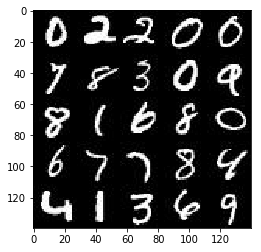

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

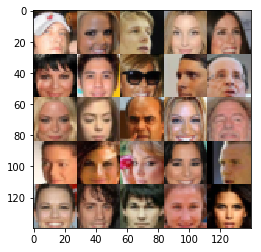

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, shape=(None,
                                                  image_width,
                                                  image_height,
                                                  image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None,
                                               z_dim))
    
    learning_rate = tf.placeholder(tf.float32)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)

    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size

    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

        saver.save(sess, './generator.ckpt')
    
    return losses
      
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7296... Generator Loss: 1.1803
Epoch 1/2... Discriminator Loss: 0.2669... Generator Loss: 1.8837
Epoch 1/2... Discriminator Loss: 0.1060... Generator Loss: 2.8491
Epoch 1/2... Discriminator Loss: 0.3042... Generator Loss: 2.2849
Epoch 1/2... Discriminator Loss: 2.3494... Generator Loss: 0.1408
Epoch 1/2... Discriminator Loss: 1.6620... Generator Loss: 0.4121
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.5505
Epoch 1/2... Discriminator Loss: 1.2293... Generator Loss: 0.7238
Epoch 1/2... Discriminator Loss: 1.1172... Generator Loss: 0.8534
Epoch 1/2... Discriminator Loss: 1.1679... Generator Loss: 0.8999


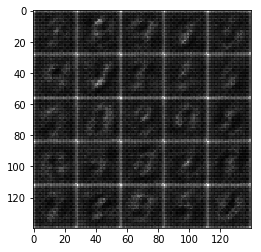

Epoch 1/2... Discriminator Loss: 1.2616... Generator Loss: 0.6970
Epoch 1/2... Discriminator Loss: 1.2547... Generator Loss: 1.1800
Epoch 1/2... Discriminator Loss: 1.1602... Generator Loss: 0.7725
Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 1.4006
Epoch 1/2... Discriminator Loss: 1.1405... Generator Loss: 0.6751
Epoch 1/2... Discriminator Loss: 1.0933... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 1.1172... Generator Loss: 1.2742
Epoch 1/2... Discriminator Loss: 1.1883... Generator Loss: 0.5679
Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 0.8697
Epoch 1/2... Discriminator Loss: 0.9856... Generator Loss: 1.5295


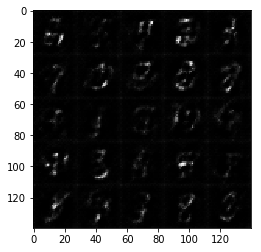

Epoch 1/2... Discriminator Loss: 0.9121... Generator Loss: 0.9048
Epoch 1/2... Discriminator Loss: 1.0888... Generator Loss: 0.5784
Epoch 1/2... Discriminator Loss: 0.9906... Generator Loss: 1.2987
Epoch 1/2... Discriminator Loss: 0.9125... Generator Loss: 0.9013
Epoch 1/2... Discriminator Loss: 0.8450... Generator Loss: 0.9669
Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.4525
Epoch 1/2... Discriminator Loss: 0.9166... Generator Loss: 1.3387
Epoch 1/2... Discriminator Loss: 0.7604... Generator Loss: 1.1617
Epoch 1/2... Discriminator Loss: 0.8078... Generator Loss: 1.4575
Epoch 1/2... Discriminator Loss: 0.8121... Generator Loss: 0.8469


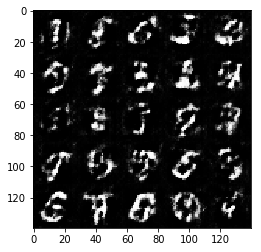

Epoch 1/2... Discriminator Loss: 0.6415... Generator Loss: 1.1723
Epoch 1/2... Discriminator Loss: 0.7958... Generator Loss: 1.8858
Epoch 1/2... Discriminator Loss: 0.6687... Generator Loss: 1.0886
Epoch 1/2... Discriminator Loss: 0.6839... Generator Loss: 1.1092
Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 0.5137
Epoch 1/2... Discriminator Loss: 0.8965... Generator Loss: 0.7509
Epoch 1/2... Discriminator Loss: 0.5636... Generator Loss: 1.4858
Epoch 1/2... Discriminator Loss: 0.8033... Generator Loss: 2.2123
Epoch 1/2... Discriminator Loss: 0.7637... Generator Loss: 0.9011
Epoch 1/2... Discriminator Loss: 0.6211... Generator Loss: 1.4685


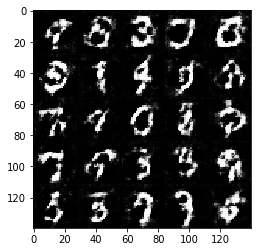

Epoch 1/2... Discriminator Loss: 0.6556... Generator Loss: 1.1273
Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 1.8249
Epoch 1/2... Discriminator Loss: 0.7412... Generator Loss: 1.1420
Epoch 1/2... Discriminator Loss: 1.1403... Generator Loss: 0.5125
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 1.8444
Epoch 1/2... Discriminator Loss: 0.7676... Generator Loss: 1.2317
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 0.7346
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 1.5127
Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 0.7226
Epoch 2/2... Discriminator Loss: 1.1730... Generator Loss: 0.5559


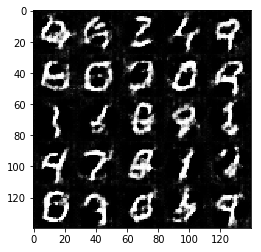

Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 1.4694
Epoch 2/2... Discriminator Loss: 0.8616... Generator Loss: 1.2385
Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 2.0096
Epoch 2/2... Discriminator Loss: 0.9788... Generator Loss: 0.8143
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 1.0193
Epoch 2/2... Discriminator Loss: 1.0893... Generator Loss: 1.4717
Epoch 2/2... Discriminator Loss: 1.0141... Generator Loss: 0.7924
Epoch 2/2... Discriminator Loss: 1.0784... Generator Loss: 0.6227
Epoch 2/2... Discriminator Loss: 0.8866... Generator Loss: 1.1694
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 1.0719


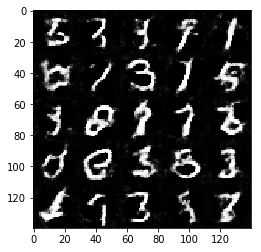

Epoch 2/2... Discriminator Loss: 0.9980... Generator Loss: 1.3862
Epoch 2/2... Discriminator Loss: 1.0789... Generator Loss: 1.4880
Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 0.4925
Epoch 2/2... Discriminator Loss: 0.9584... Generator Loss: 1.3565
Epoch 2/2... Discriminator Loss: 0.9166... Generator Loss: 0.9955
Epoch 2/2... Discriminator Loss: 0.9181... Generator Loss: 1.1097
Epoch 2/2... Discriminator Loss: 1.0070... Generator Loss: 0.8098
Epoch 2/2... Discriminator Loss: 0.9172... Generator Loss: 1.0434
Epoch 2/2... Discriminator Loss: 1.0281... Generator Loss: 0.7756
Epoch 2/2... Discriminator Loss: 1.0681... Generator Loss: 0.5857


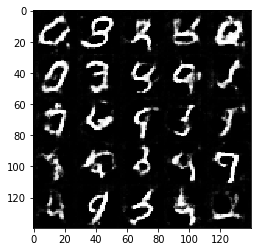

Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 0.8409
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 1.4329
Epoch 2/2... Discriminator Loss: 0.9644... Generator Loss: 1.1440
Epoch 2/2... Discriminator Loss: 0.8995... Generator Loss: 1.2405
Epoch 2/2... Discriminator Loss: 1.1023... Generator Loss: 1.4788
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 0.5136
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 0.5594
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 2.1289
Epoch 2/2... Discriminator Loss: 1.1074... Generator Loss: 0.6213
Epoch 2/2... Discriminator Loss: 0.9455... Generator Loss: 0.9056


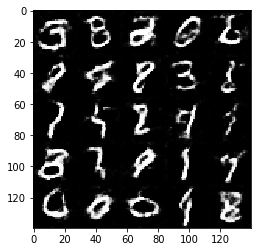

Epoch 2/2... Discriminator Loss: 0.9629... Generator Loss: 1.4271
Epoch 2/2... Discriminator Loss: 1.2991... Generator Loss: 0.4268
Epoch 2/2... Discriminator Loss: 1.1215... Generator Loss: 0.5727
Epoch 2/2... Discriminator Loss: 0.9236... Generator Loss: 0.9701
Epoch 2/2... Discriminator Loss: 0.9651... Generator Loss: 0.7965
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 0.9496
Epoch 2/2... Discriminator Loss: 0.9078... Generator Loss: 0.9952
Epoch 2/2... Discriminator Loss: 0.9740... Generator Loss: 0.7086
Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 0.9659
Epoch 2/2... Discriminator Loss: 0.8447... Generator Loss: 1.0350


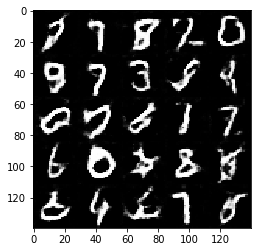

Epoch 2/2... Discriminator Loss: 0.8788... Generator Loss: 0.9687
Epoch 2/2... Discriminator Loss: 1.4016... Generator Loss: 2.4062
Epoch 2/2... Discriminator Loss: 0.8829... Generator Loss: 1.1747


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7895... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 0.3048... Generator Loss: 1.9873
Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 1.6700
Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 1.9129
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 1.5194
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 2.2176
Epoch 1/1... Discriminator Loss: 0.5459... Generator Loss: 1.9565
Epoch 1/1... Discriminator Loss: 0.4032... Generator Loss: 1.8557
Epoch 1/1... Discriminator Loss: 0.3648... Generator Loss: 1.9667


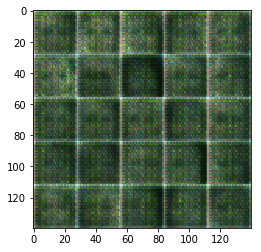

Epoch 1/1... Discriminator Loss: 0.1930... Generator Loss: 3.0033
Epoch 1/1... Discriminator Loss: 0.1795... Generator Loss: 2.6870
Epoch 1/1... Discriminator Loss: 0.1266... Generator Loss: 2.9564
Epoch 1/1... Discriminator Loss: 0.0931... Generator Loss: 3.3247
Epoch 1/1... Discriminator Loss: 0.1018... Generator Loss: 3.0300
Epoch 1/1... Discriminator Loss: 0.0894... Generator Loss: 3.4117
Epoch 1/1... Discriminator Loss: 0.0908... Generator Loss: 3.1026
Epoch 1/1... Discriminator Loss: 0.0610... Generator Loss: 3.7675
Epoch 1/1... Discriminator Loss: 0.0422... Generator Loss: 4.1080
Epoch 1/1... Discriminator Loss: 0.0582... Generator Loss: 3.9428


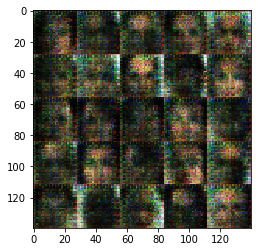

Epoch 1/1... Discriminator Loss: 0.0391... Generator Loss: 4.0071
Epoch 1/1... Discriminator Loss: 0.0343... Generator Loss: 4.1262
Epoch 1/1... Discriminator Loss: 0.0337... Generator Loss: 4.2774
Epoch 1/1... Discriminator Loss: 0.0322... Generator Loss: 4.2102
Epoch 1/1... Discriminator Loss: 0.0347... Generator Loss: 4.2585
Epoch 1/1... Discriminator Loss: 0.0194... Generator Loss: 4.7541
Epoch 1/1... Discriminator Loss: 0.0159... Generator Loss: 5.0412
Epoch 1/1... Discriminator Loss: 0.0166... Generator Loss: 4.9609
Epoch 1/1... Discriminator Loss: 0.0169... Generator Loss: 4.8836
Epoch 1/1... Discriminator Loss: 0.0131... Generator Loss: 4.8709


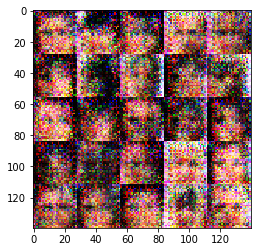

Epoch 1/1... Discriminator Loss: 0.0193... Generator Loss: 4.9179
Epoch 1/1... Discriminator Loss: 0.0174... Generator Loss: 4.8244
Epoch 1/1... Discriminator Loss: 0.0159... Generator Loss: 5.5445
Epoch 1/1... Discriminator Loss: 0.6856... Generator Loss: 1.3469
Epoch 1/1... Discriminator Loss: 0.2326... Generator Loss: 2.6951
Epoch 1/1... Discriminator Loss: 0.3569... Generator Loss: 2.2276
Epoch 1/1... Discriminator Loss: 1.9647... Generator Loss: 0.2314
Epoch 1/1... Discriminator Loss: 1.7277... Generator Loss: 0.2535
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 3.2834
Epoch 1/1... Discriminator Loss: 1.9908... Generator Loss: 0.1994


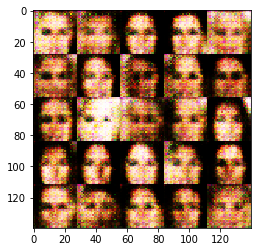

Epoch 1/1... Discriminator Loss: 0.2480... Generator Loss: 3.0091
Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 1.5201
Epoch 1/1... Discriminator Loss: 1.8798... Generator Loss: 5.9904
Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 5.0349
Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 1.6276
Epoch 1/1... Discriminator Loss: 1.7253... Generator Loss: 0.2531
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 4.2864
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 2.4622
Epoch 1/1... Discriminator Loss: 0.4373... Generator Loss: 2.8545


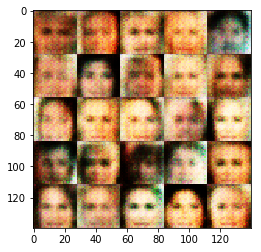

Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 1.5622
Epoch 1/1... Discriminator Loss: 1.6030... Generator Loss: 0.3419
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 1.5952
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 1.9811
Epoch 1/1... Discriminator Loss: 0.1532... Generator Loss: 3.5482
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 1.2510
Epoch 1/1... Discriminator Loss: 0.5356... Generator Loss: 1.7369


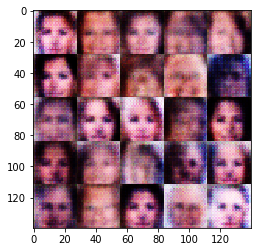

Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 1.3881
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 3.1606
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 1.8942
Epoch 1/1... Discriminator Loss: 2.1411... Generator Loss: 0.1882
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 2.7716
Epoch 1/1... Discriminator Loss: 0.6811... Generator Loss: 4.6500
Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 2.5842
Epoch 1/1... Discriminator Loss: 2.2893... Generator Loss: 0.1822
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 6.5022


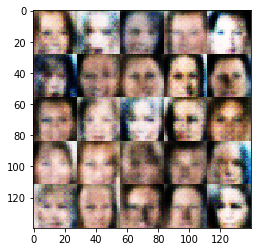

Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 4.3053
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 4.8381
Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 3.8031
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 2.7605... Generator Loss: 0.0811
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 0.2440... Generator Loss: 4.4817


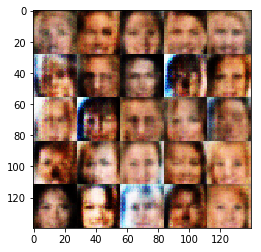

Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 4.0552
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 3.4794
Epoch 1/1... Discriminator Loss: 0.3029... Generator Loss: 3.8440
Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 5.4413
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.4205
Epoch 1/1... Discriminator Loss: 0.1253... Generator Loss: 4.0824
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 0.6455... Generator Loss: 1.5216
Epoch 1/1... Discriminator Loss: 0.1090... Generator Loss: 3.7116
Epoch 1/1... Discriminator Loss: 0.1275... Generator Loss: 3.4936


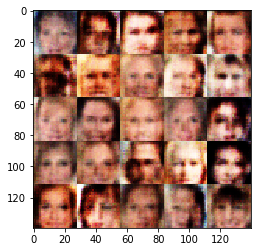

Epoch 1/1... Discriminator Loss: 0.1894... Generator Loss: 4.2432
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 0.2932... Generator Loss: 1.8246
Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 2.7085
Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 1.4028
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.3455
Epoch 1/1... Discriminator Loss: 0.4413... Generator Loss: 4.8393
Epoch 1/1... Discriminator Loss: 0.2230... Generator Loss: 2.9335
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.4202


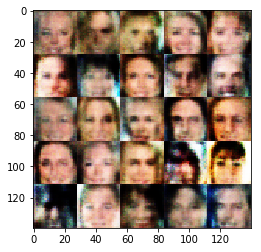

Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 4.9546
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 0.4135... Generator Loss: 1.9127
Epoch 1/1... Discriminator Loss: 0.5697... Generator Loss: 4.1555
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.4116
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 1.1477
Epoch 1/1... Discriminator Loss: 1.8883... Generator Loss: 0.2196
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 1.6708
Epoch 1/1... Discriminator Loss: 0.3349... Generator Loss: 2.0050
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 3.9575


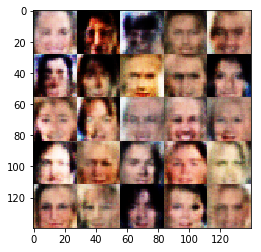

Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 1.9258
Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 4.0320
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 5.7110
Epoch 1/1... Discriminator Loss: 0.4828... Generator Loss: 1.5451
Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 4.1948
Epoch 1/1... Discriminator Loss: 0.3130... Generator Loss: 2.5557
Epoch 1/1... Discriminator Loss: 0.5380... Generator Loss: 1.3076
Epoch 1/1... Discriminator Loss: 0.2588... Generator Loss: 2.3927


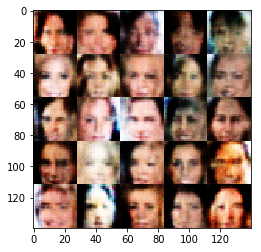

Epoch 1/1... Discriminator Loss: 0.2207... Generator Loss: 3.1162
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 1.2756
Epoch 1/1... Discriminator Loss: 0.1852... Generator Loss: 5.1830
Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 1.2611
Epoch 1/1... Discriminator Loss: 2.3020... Generator Loss: 3.3342
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 2.6735
Epoch 1/1... Discriminator Loss: 0.5788... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 0.4481... Generator Loss: 2.0643
Epoch 1/1... Discriminator Loss: 0.2906... Generator Loss: 4.2575
Epoch 1/1... Discriminator Loss: 0.3642... Generator Loss: 5.7541


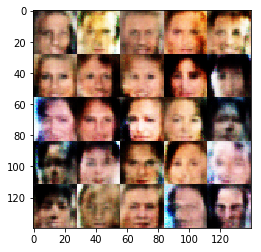

Epoch 1/1... Discriminator Loss: 0.2915... Generator Loss: 4.0638
Epoch 1/1... Discriminator Loss: 0.4249... Generator Loss: 1.3658
Epoch 1/1... Discriminator Loss: 0.4560... Generator Loss: 4.4033
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.3101
Epoch 1/1... Discriminator Loss: 0.2408... Generator Loss: 3.2757
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 2.0434
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 1.1860
Epoch 1/1... Discriminator Loss: 0.3494... Generator Loss: 3.8736


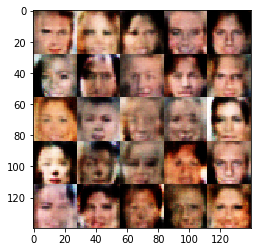

Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 0.3366... Generator Loss: 2.4373
Epoch 1/1... Discriminator Loss: 0.3830... Generator Loss: 4.4378
Epoch 1/1... Discriminator Loss: 0.2640... Generator Loss: 3.7647
Epoch 1/1... Discriminator Loss: 0.2459... Generator Loss: 2.7453
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 1.5490
Epoch 1/1... Discriminator Loss: 0.4367... Generator Loss: 3.5167
Epoch 1/1... Discriminator Loss: 0.1686... Generator Loss: 3.0586
Epoch 1/1... Discriminator Loss: 0.1194... Generator Loss: 3.4178
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 6.9137


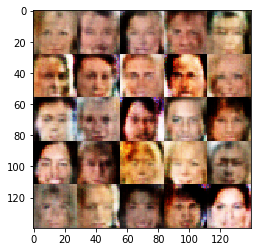

Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 0.2255... Generator Loss: 3.8640
Epoch 1/1... Discriminator Loss: 0.1898... Generator Loss: 2.9284
Epoch 1/1... Discriminator Loss: 0.2892... Generator Loss: 2.6279
Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 2.8204
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 4.5982
Epoch 1/1... Discriminator Loss: 0.1919... Generator Loss: 3.0433


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.